# Speeding up Python for Linear Algebra Tasks

## Numba: Just-In-Time Compilation

Numba uses LLVM to compile Python functions to machine code at runtime.
Key points:

-   **Decorators**: Use `@njit` (nopython mode) for best speed.  
-   **Type inference**: Numba infers types on first run, then compiles
    specialized code.  
-   **Compilation overhead**: The first call incurs compilation time;
    subsequent calls are fast.  
-   **Object mode vs nopython mode**: Always aim for nopython mode to
    avoid Python object overhead.

**Example: Matrix–Vector Multiplication**

In [1]:
from numba import njit
import numpy as np
import time # for timing

@njit
def matvec(A, x):
    m, n = A.shape
    y = np.zeros(m)
    for i in range(m):
        temp = 0.0
        for j in range(n):
            temp += A[i, j] * x[j]
        y[i] = temp
    return y

# Prepare data
dim = 500
A = np.random.rand(dim, dim)
x = np.random.rand(dim)

# Using NumPy's dot product
start = time.time()
y0 = A @ x
end = time.time()
print("NumPy time (ms): ", 1e3*(end - start))

# Using Numba's compiled function
y0 = matvec(A, x) # First call for compilation

start = time.time()
y1 = matvec(A, x)
end = time.time()
print("Numba time (ms): ", 1e3*(end - start))

NumPy time (ms):  0.3254413604736328
Numba time (ms):  0.29158592224121094

## JAX: XLA Compilation and Automatic Differentiation

JAX is a high-performance library from Google Research that extends
NumPy with just-in-time compilation and automatic differentiation. It -
Compiles array operations via XLA, fusing kernels and reducing Python
overhead. - Supports GPU and TPU backends with minimal code changes. -
Provides `grad` for gradients of scalar functions, enabling optimisation
and machine-learning tasks. - Offers advanced transformations like
`vmap` (vectorisation) and `pmap` (parallelism on multiple devices).

JAX is widely used in deep learning frameworks (e.g. Flax, Haiku),
reinforcement learning, and scientific research (including physics
simulations), thanks to its blend of speed and flexibility.

### Comparing Accuracy: AD vs Finite Differences

Below is a Quarto code cell that plots the error of finite differences
(varying step size $h$) and automatic differentiation against the true
derivative of $f(x) = e^{\sin(x)}$ at $x=1.0$.

AD error: 0.0
FD minimum error: 7.006839553014288e-12

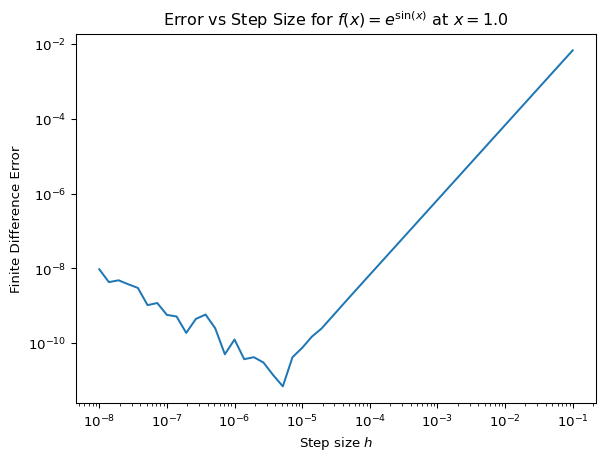

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt # for plotting

# Set JAX to use 64-bit floats
jax.config.update("jax_enable_x64", True)

# Define function and true derivative
def f_np(x):
    return np.exp(np.sin(x))

def df_true(x):
    return np.cos(x) * np.exp(np.sin(x))

# Point of evaluation
x0 = 1.0

# Finite-difference errors for varying h
hs = np.logspace(-8, -1, 50)
errors_fd = []
for h in hs:
    df_fd = (f_np(x0 + h) - f_np(x0 - h)) / (2 * h)
    errors_fd.append(abs(df_fd - df_true(x0)))

# Automatic differentiation error (constant)
df_ad = jax.grad(lambda x: jnp.exp(jnp.sin(x)))(x0)
error_ad = abs(np.array(df_ad) - df_true(x0))

print(f"AD error: {error_ad}")
print(f"FD minimum error: {min(errors_fd)}")

# Plot
plt.loglog(hs, errors_fd)
plt.xlabel("Step size $h$")
plt.ylabel("Finite Difference Error")
plt.title(r"Error vs Step Size for $f(x) = e^{\sin(x)}$ at $x=1.0$")
plt.show()